In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import hist
import vector
import numba

In [2]:
events = NanoEventsFactory.from_root("root://eosuser.cern.ch://eos/user/d/dvalsecc/EFT_PhD_Course/samples/SSWW_EFT_1.root", schemaclass=NanoAODSchema).events()

In [3]:
events

<NanoEventsArray [<event 1:1:1>, ... <event 1:1:375>] type='373663 * event'>

In [8]:
events.LHEPart.pdgId[0:10].tolist()

[[2, 2, -11, 12, -13, 14, 1, 1],
 [-1, 2, -11, 12, -13, 14, 1, -2],
 [2, -1, -11, 12, -15, 16, 1, -2],
 [2, 2, -13, 14, -13, 14, 1, 1],
 [2, 2, -11, 12, -13, 14, 1, 1],
 [2, 2, -13, 14, -15, 16, 1, 1],
 [2, 2, -11, 12, -15, 16, 1, 1],
 [2, 2, -11, 12, -15, 16, 1, 1],
 [2, 2, -11, 12, -11, 12, 1, 1],
 [-2, 1, 13, -14, 15, -16, 2, -1]]

(array([     0.,      0.,      0.,      0.,      0., 373663.,      0.,
             0.,      0.,      0.]),
 array([7.5, 7.6, 7.7, 7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5]),
 <BarContainer object of 10 artists>)

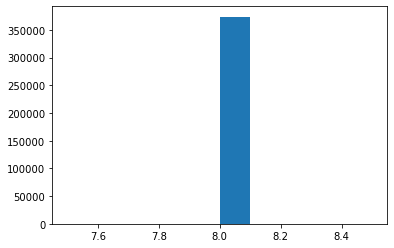

In [3]:
plt.hist(ak.num(events.LHEPart, axis=1))

In [4]:
W1 = events.LHEPart[:, 2] + events.LHEPart[:, 3]
W2 = events.LHEPart[:, 4] + events.LHEPart[:, 5]

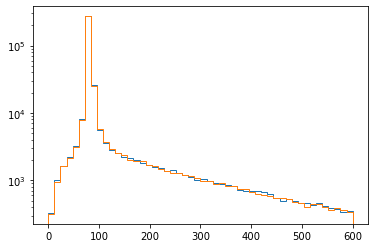

In [5]:
plt.hist(W1.mass, bins=50, range=(0, 600), histtype="step");
plt.hist(W2.mass, bins=50, range=(0, 600), histtype="step");

plt.yscale("log")

In [21]:
events.PuppiMET.phi

<Array [1.48, 0.805, -1.69, ... 1.55, 1.41] type='373663 * float32[parameters={"...'>

In [28]:
num_jets = ak.sum(events.Jet.pt > 30, axis=1)

(array([6.5000e+01, 1.6670e+03, 7.5510e+03, 2.3394e+04, 5.5720e+03,
        2.5190e+03, 1.1330e+03, 7.4000e+01, 2.0000e+01, 5.0000e+00]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <BarContainer object of 10 artists>)

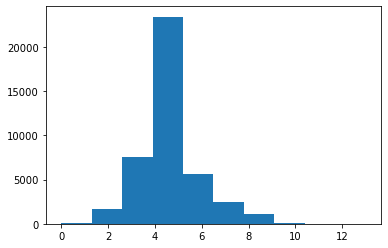

In [29]:
plt.hist(num_jets)

In [4]:
def delta_eta(obj1, obj2):
    return abs(obj1.eta - obj2.eta)

def mjj(obj1, obj2):
    return (obj1 + obj2).mass

In [5]:
deltaEta = events.Jet.metric_table(events.Jet, metric=delta_eta)
Mjj = events.Jet.metric_table(events.Jet, metric=mjj)

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


In [25]:
@numba.njit
def get_max_mjj(njets, mjjs):
    out = -1 * np.ones((len(njets), 2))
    mjj_best = np.ones(len(njets))
    for iev in range(len(njets)):
        max_mjj = -1.
        best_1 = -1
        best_2 = -2
        for i in range(njets[iev]-1):
            for j in range(i+1, njets[iev]):
                #print(i, j, mjjs[iev][i][j])
                if mjjs[iev][i][j] > max_mjj:
                    best_1 = i
                    best_2 = j
                    max_mjj =  mjjs[iev][i][j]
        out[iev][0] = best_1
        out[iev][1] = best_2
        mjj_best[iev] = max_mjj
    return out, mjj_best

In [22]:
%%timeit
get_max_mjj(ak.num(events.Jet, axis=1),  Mjj)

74.6 ms ± 3.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [93]:
largest_mjj_idx, largest_mjj = get_max_mjj(ak.num(events.Jet, axis=1),  Mjj)

(array([2.4920e+03, 1.5836e+04, 3.1690e+04, 4.2373e+04, 4.6052e+04,
        4.4904e+04, 4.0489e+04, 3.4637e+04, 2.8473e+04, 2.2519e+04,
        1.7723e+04, 1.3499e+04, 9.9020e+03, 7.2430e+03, 5.2660e+03,
        3.5540e+03, 2.3940e+03, 1.6510e+03, 1.1450e+03, 6.6000e+02,
        4.6300e+02, 2.6900e+02, 1.7700e+02, 1.0100e+02, 5.3000e+01,
        3.3000e+01, 3.0000e+01, 2.0000e+01, 3.0000e+00, 6.0000e+00,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-1.00000000e+00,  2.96791309e+02,  5.94582617e+02,  8.92373926e+02,
         1.19016523e+03,  1.48795654e+03,  1.78574785e+03,  2.08353916e+03,
         2.38133047e+03,  2.67912178e+03,  2.97691309e+03,  3.27470439e+03,
         3.57249570e+03,  3.87028701e+03,  4.16807832e+03,  4.46586963e+03,
         4.763

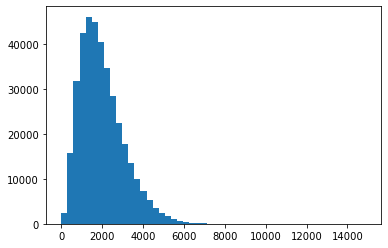

In [29]:
plt.hist(largest_mjj, bins=50)

In [32]:
largest_mjj_idx[:,0]

array([0., 2., 0., ..., 0., 0., 1.])

In [53]:
events.Jet.eta[ak.Array(largest_mjj_idx[:,0][:,None])]

<Array [[[-1.93, 0.42, ... -2.91, 4.94]]] type='373663 * 1 * var * float32[param...'>

In [61]:
idx_pairs_sorted = ak.argsort(Mjj, axis=1)

In [92]:
loc_idk = ak.local_index(events.Jet.eta)

In [116]:
mask = (loc_idk == largest_mjj_idx[:,0]) | (loc_idk == largest_mjj_idx[:,1]) 

In [117]:
mask[2].tolist()

[True, True, False, False, False, False, False]

In [120]:
events.Jet.eta[mask][0:10].tolist()

[[-1.927490234375, 2.67236328125],
 [-2.84375, 4.94140625],
 [0.27813720703125, -0.006920814514160156],
 [0.9996337890625, -0.254150390625],
 [-0.9144287109375, 1.81103515625],
 [-0.1553955078125, -0.50244140625],
 [-1.20556640625, 0.2705078125],
 [-0.513427734375, -1.01123046875],
 [-0.31689453125, 0.204010009765625],
 [-1.049072265625, 3.1982421875]]

In [121]:
ak.max?

Signature: ak.max(array, axis=None, keepdims=False, initial=None, mask_identity=True)
Docstring:
Args:
    array: Data to maximize.
    axis (None or int): If None, combine all values from the array into
        a single scalar result; if an int, group by that axis: `0` is the
        outermost, `1` is the first level of nested lists, etc., and
        negative `axis` counts from the innermost: `-1` is the innermost,
        `-2` is the next level up, etc.
    keepdims (bool): If False, this reducer decreases the number of
        dimensions by 1; if True, the reduced values are wrapped in a new
        length-1 dimension so that the result of this operation may be
        broadcasted with the original array.
    initial (None or number): The minimum value of an output element, as
        an alternative to the numeric type's natural identity (e.g. negative
        infinity for floating-point types, a minimum integer for integer types).
        If you use `initial`, you might also want 

In [122]:
events.Electron.charge

<Array [[-1, -1], [1, -1, 1, ... [-1], [-1]] type='373663 * var * int32[paramete...'>